In [1]:
import pandas as pd
import os

df = pd.read_csv("./datasets/forest_features_20240701.csv")
df.head()

,date,1wk_WIS,1_week_roc,is_wis_above_avg,1st_deriv_stencil,week_of_year,moving_avg_WIS,lagged_1wk_WIS,loc_code,holiday_last_week,population
0,2023-10-28,19.51,0.320000,0,7.333333,43,13.273333,13.51,18,0,6785528
1,2023-11-04,6.51,0.181818,0,4.166667,44,13.176667,19.51,18,0,6785528
2,2023-11-11,45.84,0.205128,0,27.750000,45,23.953333,6.51,18,0,6785528
3,2023-11-18,11.54,0.851064,0,16.416667,46,21.296667,45.84,18,1,6785528
4,2023-11-25,37.36,-0.034483,0,25.750000,47,31.580000,11.54,18,0,6785528


In [2]:
# Add the median quantile prediction and actual hospitalizations
all_data = []

directory = "LosAlamos_NAU-CModel_Flu"
for file in os.listdir(directory):
    file_path = os.path.join(directory, file)
    csv_df = pd.read_csv(file_path)

    # Filter for median predictions
    filtered_csv_df = csv_df[csv_df["output_type_id"] == "0.5"]
    filtered_csv_df = filtered_csv_df[filtered_csv_df["horizon"] == 1]
    filtered_csv_df.rename(
        columns={"reference_date": "date", "location": "loc_code"}, inplace=True
    )

    all_data.append(filtered_csv_df)

aggregated_df = pd.concat(all_data, ignore_index=True)
aggregated_df

,date,target,horizon,target_end_date,loc_code,output_type,output_type_id,value
0,2023-10-21,wk inc flu hosp,1,2023-10-28,11,quantile,0.5,0.000000
1,2023-10-21,wk inc flu hosp,1,2023-10-28,72,quantile,0.5,117.498152
2,2023-10-21,wk inc flu hosp,1,2023-10-28,12,quantile,0.5,198.435375
3,2023-10-21,wk inc flu hosp,1,2023-10-28,01,quantile,0.5,14.159718
4,2023-10-21,wk inc flu hosp,1,2023-10-28,02,quantile,0.5,7.044904
...,...,...,...,...,...,...,...,...
1265,2024-04-06,wk inc flu hosp,1,2024-04-13,53,quantile,0.5,38.237101
1266,2024-04-06,wk inc flu hosp,1,2024-04-13,55,quantile,0.5,138.394057
1267,2024-04-06,wk inc flu hosp,1,2024-04-13,54,quantile,0.5,61.235295
1268,2024-04-06,wk inc flu hosp,1,2024-04-13,56,quantile,0.5,3.975788


In [3]:
df["loc_code"] = df["loc_code"].astype("int32")
df.head()

,date,1wk_WIS,1_week_roc,is_wis_above_avg,1st_deriv_stencil,week_of_year,moving_avg_WIS,lagged_1wk_WIS,loc_code,holiday_last_week,population
0,2023-10-28,19.51,0.320000,0,7.333333,43,13.273333,13.51,18,0,6785528
1,2023-11-04,6.51,0.181818,0,4.166667,44,13.176667,19.51,18,0,6785528
2,2023-11-11,45.84,0.205128,0,27.750000,45,23.953333,6.51,18,0,6785528
3,2023-11-18,11.54,0.851064,0,16.416667,46,21.296667,45.84,18,1,6785528
4,2023-11-25,37.36,-0.034483,0,25.750000,47,31.580000,11.54,18,0,6785528


In [4]:
aggregated_df = aggregated_df[aggregated_df["loc_code"] != "US"]
aggregated_df["loc_code"] = aggregated_df["loc_code"].astype("int32")
aggregated_df.head()

/tmp/ipykernel_819236/4094823712.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aggregated_df['loc_code'] = aggregated_df['loc_code'].astype('int32')


,date,target,horizon,target_end_date,loc_code,output_type,output_type_id,value
0,2023-10-21,wk inc flu hosp,1,2023-10-28,11,quantile,0.5,0.000000
1,2023-10-21,wk inc flu hosp,1,2023-10-28,72,quantile,0.5,117.498152
2,2023-10-21,wk inc flu hosp,1,2023-10-28,12,quantile,0.5,198.435375
3,2023-10-21,wk inc flu hosp,1,2023-10-28,1,quantile,0.5,14.159718
4,2023-10-21,wk inc flu hosp,1,2023-10-28,2,quantile,0.5,7.044904


In [14]:
merged_df = pd.merge(
    df,
    aggregated_df[["date", "loc_code", "value"]],
    how="left",
    left_on=["date", "loc_code"],
    right_on=["date", "loc_code"],
)
merged_df.rename(columns={"value": "pred_hosp"}, inplace=True)
merged_df.head()

,date,1wk_WIS,1_week_roc,is_wis_above_avg,1st_deriv_stencil,week_of_year,moving_avg_WIS,lagged_1wk_WIS,loc_code,holiday_last_week,population,pred_hosp
0,2023-10-28,19.51,0.320000,0,7.333333,43,13.273333,13.51,18,0,6785528,14.324939
1,2023-11-04,6.51,0.181818,0,4.166667,44,13.176667,19.51,18,0,6785528,14.324939
2,2023-11-11,45.84,0.205128,0,27.750000,45,23.953333,6.51,18,0,6785528,38.088067
3,2023-11-18,11.54,0.851064,0,16.416667,46,21.296667,45.84,18,1,6785528,38.088067
4,2023-11-25,37.36,-0.034483,0,25.750000,47,31.580000,11.54,18,0,6785528,84.159595


We need to calculate weekly observations for each location and map them to 
our existing data with the location code. 

In [15]:
from datetime import timedelta

# Read location data.
locations = pd.read_csv("datasets/locations.csv").iloc[
    1:
]  # skip first row (national ID)

# Map location codes to state abbreviations.
location_to_state = dict(zip(locations["location"], locations["abbreviation"]))

# Process reported hospitalization data.
full_hosp_data = pd.read_csv("./datasets/COVID_Reported_Data.csv")
full_hosp_data = full_hosp_data[
    ["date", "state", "previous_day_admission_influenza_confirmed"]
].sort_values(["state", "date"])
full_hosp_data["date"] = pd.to_datetime(full_hosp_data["date"])


def compute_week_observation(state_hosp_data, target_date):
    """
    Computes the hospitalization counts for a given week.

    This is necessary because the hospitalization data is provided daily,
    but we are making weekly predictions.
    """
    observation = 0
    state_hosp_data.loc[:, "date"] = pd.to_datetime(state_hosp_data["date"])
    target_date_obj = pd.to_datetime(target_date)

    for i in range(7):
        current_date = target_date_obj - timedelta(days=i)

        # Check if the current date is in the DataFrame
        filtered_data = state_hosp_data.loc[
            state_hosp_data["date"] == current_date,
            "previous_day_admission_influenza_confirmed",
        ]

        if filtered_data.empty:
            print(f"No data found for date: {current_date}")
            continue

        try:
            observation += filtered_data.values[0]
        except IndexError as e:
            print(f"An error occurred: {e}")
            print(f"Data for date {current_date} seems to be missing.")
            return None

    return observation


def get_state_hosp_data(
    full_hosp_data: pd.DataFrame, location_to_state: dict, state_code: str
) -> pd.DataFrame:
    """Filters a single state's hospitalization data from the full dataset."""
    state_abbrev = location_to_state[state_code]
    return full_hosp_data[full_hosp_data["state"] == state_abbrev]

In [17]:
import numpy as np

merged_df["actual_hosp"] = np.nan
merged_df["loc_code"] = merged_df["loc_code"].apply(lambda x: str(x).zfill(2))
merged_df["date"] = pd.to_datetime(merged_df["date"])

for index, row in merged_df.iterrows():
    # The dates in each row are a 'predict-from' date
    # We want the hospitalizations 1 week into the future.
    target_date = row["date"] + timedelta(weeks=1)
    location_code = row["loc_code"]
    state_df = get_state_hosp_data(full_hosp_data, location_to_state, location_code)
    row["actual_hosp"] = compute_week_observation(state_df, target_date)
    merged_df.iloc[index] = row

merged_df.head()

,date,1wk_WIS,1_week_roc,is_wis_above_avg,1st_deriv_stencil,week_of_year,moving_avg_WIS,lagged_1wk_WIS,loc_code,holiday_last_week,population,pred_hosp,actual_hosp
0,2023-10-28,19.51,0.320000,0,7.333333,43,13.273333,13.51,18,0,6785528,14.324939,39.0
1,2023-11-04,6.51,0.181818,0,4.166667,44,13.176667,19.51,18,0,6785528,14.324939,47.0
2,2023-11-11,45.84,0.205128,0,27.750000,45,23.953333,6.51,18,0,6785528,38.088067,87.0
3,2023-11-18,11.54,0.851064,0,16.416667,46,21.296667,45.84,18,1,6785528,38.088067,84.0
4,2023-11-25,37.36,-0.034483,0,25.750000,47,31.580000,11.54,18,0,6785528,84.159595,138.0


In [18]:
merged_df["is_prediction_over"] = merged_df["pred_hosp"] > merged_df["actual_hosp"]
merged_df.head()

,date,1wk_WIS,1_week_roc,is_wis_above_avg,1st_deriv_stencil,week_of_year,moving_avg_WIS,lagged_1wk_WIS,loc_code,holiday_last_week,population,pred_hosp,actual_hosp,is_prediction_over
0,2023-10-28,19.51,0.320000,0,7.333333,43,13.273333,13.51,18,0,6785528,14.324939,39.0,False
1,2023-11-04,6.51,0.181818,0,4.166667,44,13.176667,19.51,18,0,6785528,14.324939,47.0,False
2,2023-11-11,45.84,0.205128,0,27.750000,45,23.953333,6.51,18,0,6785528,38.088067,87.0,False
3,2023-11-18,11.54,0.851064,0,16.416667,46,21.296667,45.84,18,1,6785528,38.088067,84.0,False
4,2023-11-25,37.36,-0.034483,0,25.750000,47,31.580000,11.54,18,0,6785528,84.159595,138.0,False


In [19]:
merged_df.to_csv("./datasets/forest_features_20240702.csv", index=False)

## Note
The stencil derivative takes future data points into account. 

In [22]:
"""Prepare the data."""

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

df = merged_df.copy()
df.dropna(inplace=True)

features = [
    "1_week_roc",
    "week_of_year",
    "moving_avg_WIS",
    "lagged_1wk_WIS",
    "holiday_last_week",
    "1st_deriv_stencil",
]
X = df[features]
y = df["is_prediction_over"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
"""Train and evaluate the RF model."""

from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

       False       0.85      0.93      0.89       145
        True       0.82      0.66      0.73        68

    accuracy                           0.85       213
   macro avg       0.84      0.80      0.81       213
weighted avg       0.84      0.85      0.84       213



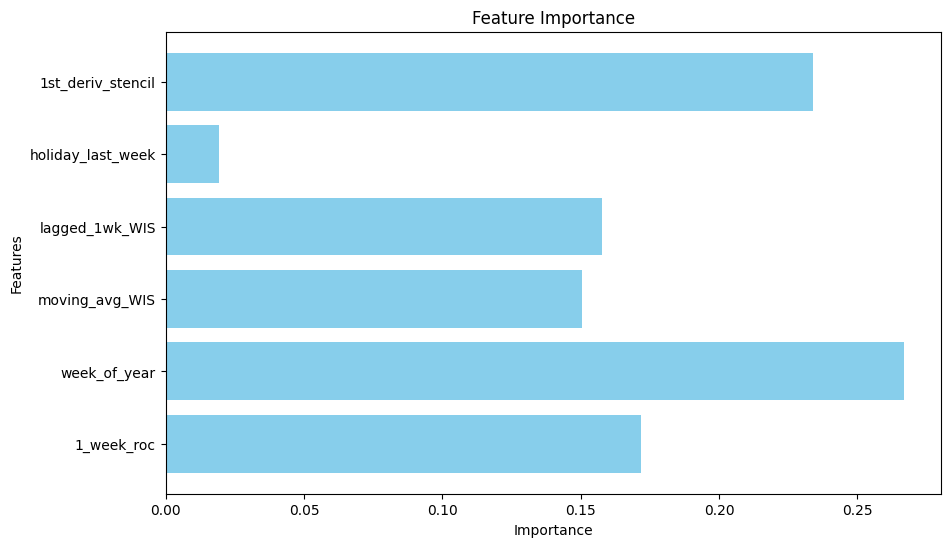

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature Importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Plot Feature Importances
plt.figure(figsize=(10, 6), dpi=100)
plt.barh(feature_names, importances, color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

In [25]:
"""Recursive Feature Elimination -- 5 Features"""

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model for RFE
model = LogisticRegression()

# Initialize RFE with the logistic regression model
rfe = RFE(estimator=model, n_features_to_select=5)

# Fit RFE
rfe = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Reduce the dataset to selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# Train Random Forest model with reduced features
rf_model_rfe = RandomForestClassifier(random_state=42)
rf_model_rfe.fit(X_train_rfe, y_train)

# Evaluate the reduced model
y_pred_rfe = rf_model_rfe.predict(X_test_rfe)
print(classification_report(y_test, y_pred_rfe))

Selected Features: Index(['1_week_roc', 'week_of_year', 'moving_avg_WIS', 'holiday_last_week',
       '1st_deriv_stencil'],
      dtype='object')
              precision    recall  f1-score   support

       False       0.85      0.93      0.89       145
        True       0.81      0.65      0.72        68

    accuracy                           0.84       213
   macro avg       0.83      0.79      0.80       213
weighted avg       0.84      0.84      0.83       213



### Removing the Stencil Derivative


In [26]:
"""Prepare the data."""

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

df = merged_df.copy()
df.dropna(inplace=True)

features = [
    "1_week_roc",
    "week_of_year",
    "moving_avg_WIS",
    "lagged_1wk_WIS",
    "holiday_last_week",
]
X = df[features]
y = df["is_prediction_over"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [27]:
"""Train and evaluate the RF model."""

from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

       False       0.82      0.92      0.87       145
        True       0.78      0.57      0.66        68

    accuracy                           0.81       213
   macro avg       0.80      0.75      0.77       213
weighted avg       0.81      0.81      0.80       213



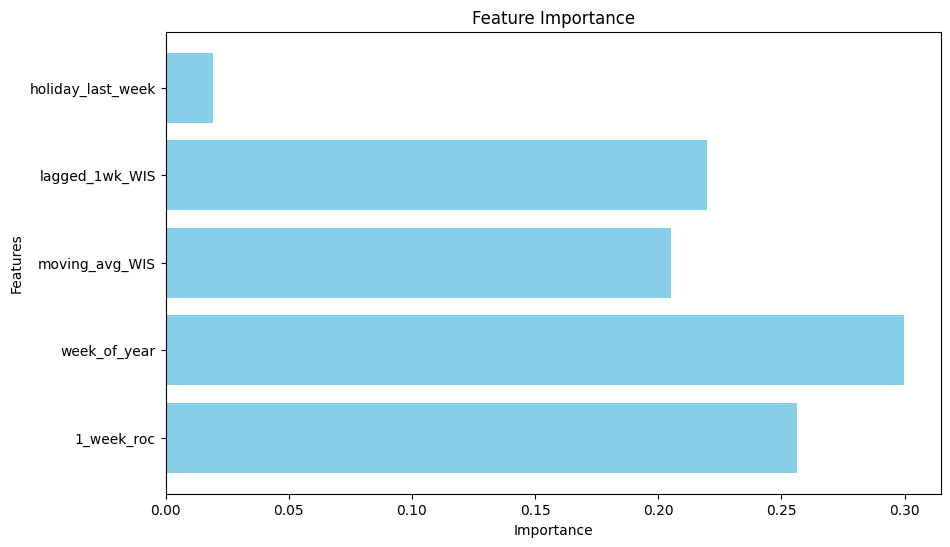

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature Importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Plot Feature Importances
plt.figure(figsize=(10, 6), dpi=100)
plt.barh(feature_names, importances, color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance")
plt.show()

In [28]:
"""Recursive Feature Elimination -- 4 Features"""

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model for RFE
model = LogisticRegression()

# Initialize RFE with the logistic regression model
rfe = RFE(estimator=model, n_features_to_select=4)

# Fit RFE
rfe = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Reduce the dataset to selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# Train Random Forest model with reduced features
rf_model_rfe = RandomForestClassifier(random_state=42)
rf_model_rfe.fit(X_train_rfe, y_train)

# Evaluate the reduced model
y_pred_rfe = rf_model_rfe.predict(X_test_rfe)
print(classification_report(y_test, y_pred_rfe))

Selected Features: Index(['1_week_roc', 'week_of_year', 'moving_avg_WIS', 'holiday_last_week'], dtype='object')
              precision    recall  f1-score   support

       False       0.81      0.88      0.84       145
        True       0.69      0.56      0.62        68

    accuracy                           0.78       213
   macro avg       0.75      0.72      0.73       213
weighted avg       0.77      0.78      0.77       213

